### ML model
- I am using the LSTM (Long Short Term Memory) model which is a kind of a Recurrent Neural Network (RNN) to predict the prices of the stocks.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import StandardScaler

In [2]:
# Loading the 1m OHLC dataset dataset

df = pd.read_csv('BTCUSDT-1m-2023-11.csv')
df = df[['open_time', 'open', 'high', 'low', 'close', 'volume']]
df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
df = df.dropna()
df.head()

,open_time,open,high,low,close,volume
0,2023-11-01 00:00:00,34651.4,34676.5,34650.0,34669.9,376.040
1,2023-11-01 00:01:00,34669.9,34684.0,34637.3,34637.4,431.177
2,2023-11-01 00:02:00,34637.4,34653.4,34632.5,34651.4,175.894
3,2023-11-01 00:03:00,34651.3,34651.4,34608.6,34621.1,476.587
4,2023-11-01 00:04:00,34621.1,34622.6,34592.0,34615.4,546.312


In [3]:
cols = list(df)[1:6] # Training variables
train_time = df['open_time']
df_for_model = (df[cols].astype(float))

In [4]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized

scaler = StandardScaler()
scaler = scaler.fit(df_for_model)
df_for_model_scaled = scaler.transform(df_for_model)
df_for_model_scaled

array([[-1.70430512, -1.69168904, -1.69464359, -1.68728218,  0.39234912],
       [-1.68718429, -1.68474878, -1.70639675, -1.71735993,  0.51842516],
       [-1.71726143, -1.71306504, -1.71083889, -1.70440336, -0.06530393],
       ...,
       [ 1.11332175,  1.10255216,  1.12037648,  1.10948575, -0.41196789],
       [ 1.1095274 ,  1.10412528,  1.12037648,  1.11494602, -0.41956854],
       [ 1.11489501,  1.12179981,  1.12046902,  1.13252993, -0.34352779]])

In [5]:
# Training and Testing data

df_for_training_scaled = df_for_model_scaled[:int(len(df_for_model)*0.67)]
df_for_testing_scaled = df_for_model_scaled[int(len(df_for_model)*0.67):]

In [6]:
trainX = [] # Features: open, high, low, close, volume
trainY = [] # Target, which is the closing price of the next minute

testX = []
testY = []

n_future = 1 # Number of minutes we want to predict into the future
n_past = 15 # Number of minutes we want to use to predict the future

In [7]:
for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training_scaled.shape[1]]) # Convert input data into 3-D array combining n_past. The shape of the array should be [samples, n_past, features], as required for LSTM network
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 3])
    
for i in range(n_past, len(df_for_testing_scaled) - n_future + 1):
    testX.append(df_for_testing_scaled[i - n_past:i, 0:df_for_testing_scaled.shape[1]]) # Convert input data into 3-D array combining n_past. The shape of the array should be [samples, n_past, features], as required for LSTM network
    testY.append(df_for_testing_scaled[i + n_future - 1:i + n_future, 3])

In [8]:
trainX, trainY = np.array(trainX), np.array(trainY) # Convert to numpy arrays from lists
testX, testY = np.array(testX), np.array(testY)

In [9]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (28929, 15, 5).
trainY shape == (28929, 1).


In [10]:
# Define Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True)) # We want this LSTM to give an output for the next LSTM because we have a stacked LSTM
model.add(LSTM(32, activation='relu', return_sequences=False)) # Next layer is just a dropout layer to prevent overfitting
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30369 (118.63 KB)
Trainable params: 30369 (118.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
# Fit model

history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/10

1628/1628 [==============================] - 15s 8ms/step - loss: 0.0391 - val_loss: 0.0059
Epoch 2/10
1628/1628 [==============================] - 9s 5ms/step - loss: 0.0226 - val_loss: 0.0016
Epoch 3/10
1628/1628 [==============================] - 8s 5ms/step - loss: 0.0214 - val_loss: 0.0026
Epoch 4/10
1628/1628 [==============================] - 11s 7ms/step - loss: 0.0199 - val_loss: 0.0014
Epoch 5/10
1628/1628 [==============================] - 13s 8ms/step - loss: 0.0191 - val_loss: 6.9768e-04
Epoch 6/10
1628/1628 [==============================] - 9s 5ms/step - loss: 0.0195 - val_loss: 0.0026
Epoch 7/10
1628/1628 [==============================] - 8s 5ms/step - loss: 0.0186 - val_loss: 0.0051
Epoch 8/10
1628/1628 [==============================] - 8s 5ms/step - loss: 0.0185 - val_loss: 0.0026
Epoch 9/10
1628/1628 [==============================] - 8s 5ms/step - loss: 0.0188 - val_loss: 0.0038
Epoch 10/10
1628/1628 [==============================] - 8s 5ms/step - los

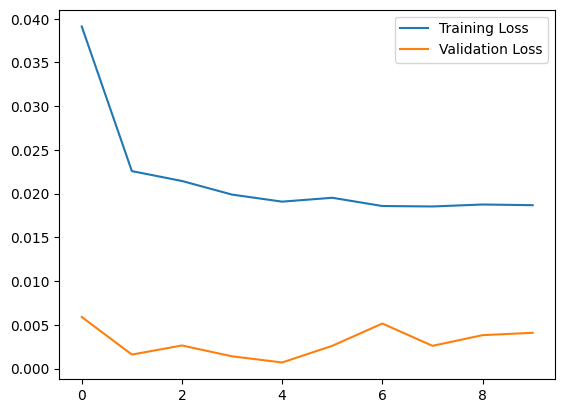

In [12]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
# The training loss indicates how well the model is fitting the training data, while the validation loss indicates how well the model fits new data
plt.legend()

In [13]:
model.evaluate(testX, testY) # Evaluating the model

446/446 [==============================] - 1s 2ms/step - loss: 0.0122


0.012187534011900425

In [14]:
# Finding Mean Absolute Error loss on the training data, which will be set as the reconstruction error threshold. If the reconstruction loss for a data point in the test set is greater than this reconstruction error threshold value then we will label this data point as an anomaly.

trainX_pred = model.predict(trainX, verbose=0)
train_mae_loss = np.mean(np.abs(trainX_pred - trainY), axis=1)
train_mae_loss

array([0.04644597, 0.07447242, 0.04981271, ..., 0.10430823, 0.09404533,
       0.07079344])

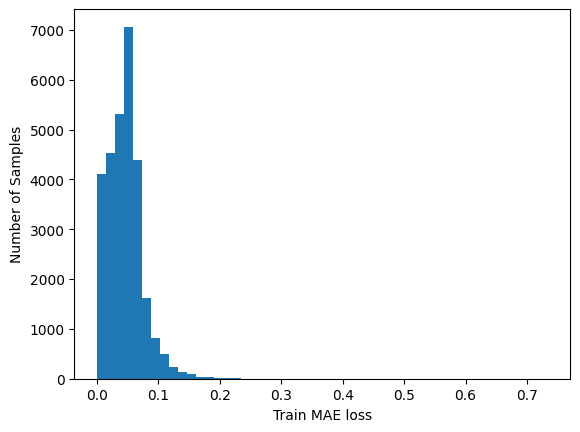

In [15]:
plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

In [16]:
threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

Reconstruction error threshold: 0.7339482265063375


In [17]:
testX_pred = model.predict(testX) # Predicted values of the test set

446/446 [==============================] - 1s 2ms/step


In [18]:
test_mae_loss = np.mean(np.abs(testX_pred - testY), axis=1)
np.max(test_mae_loss)

0.4000423158462989

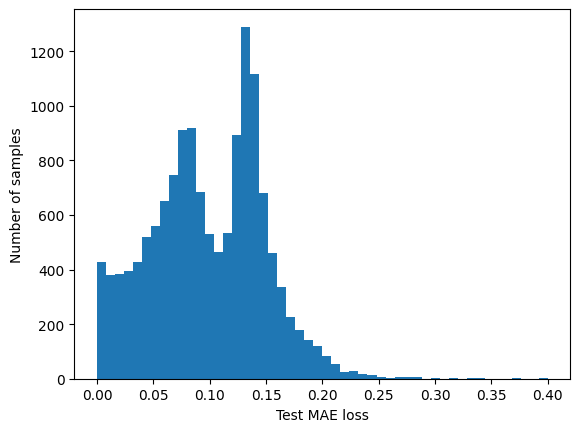

In [19]:
plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [20]:
test_score_df = pd.DataFrame(df_for_testing_scaled[n_past:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['close'] = df[n_past:].close

In [21]:
test_score_df.anomaly.value_counts()

anomaly
False    14241
Name: count, dtype: int64

Since the (max MAE_test) < (max MAE_train), the model didn't detect any anomalies in the test set. This is a good sign that the model is not overfitting.

In [22]:
''' 
Perform inverse transformation to rescale back to original range
Since we used 5 variables (open, high, low, close, volume) for transform, the inverse expects same dimensions
Therefore, let us copy our values 5 times and discard them after inverse transform
'''

forecast_copies = np.repeat(testX_pred, df_for_testing_scaled.shape[1], axis=-1)
y_pred = scaler.inverse_transform(forecast_copies)[:,3] # Select only the 3rd column (close price)

In [23]:
predictions = df[['open_time', 'close']]
predictions = predictions[int(len(predictions)*0.67)+15:]
predictions = predictions.reset_index()
predictions = predictions[['open_time', 'close']]
predictions.head()

,open_time,close
0,2023-11-21 02:39:00,37596.1
1,2023-11-21 02:40:00,37642.5
2,2023-11-21 02:41:00,37648.4
3,2023-11-21 02:42:00,37588.4
4,2023-11-21 02:43:00,37562.3


In [24]:
y_pred = pd.DataFrame(y_pred, columns=['close_pred'])
y_pred.head()

,close_pred
0,37467.824219
1,37472.085938
2,37507.140625
3,37508.003906
4,37491.519531


In [25]:
# Combining the actual and predicted values

predictions = pd.concat([predictions, y_pred], axis=1)
predictions.head()

,open_time,close,close_pred
0,2023-11-21 02:39:00,37596.1,37467.824219
1,2023-11-21 02:40:00,37642.5,37472.085938
2,2023-11-21 02:41:00,37648.4,37507.140625
3,2023-11-21 02:42:00,37588.4,37508.003906
4,2023-11-21 02:43:00,37562.3,37491.519531


### Trade Signals based on RSI and Bollinger Bands 

In [26]:
import polars as pl 
import numpy as np 
import ta

In [27]:
data_1m = pl.read_csv("BTCUSDT-1m-2023-11.csv")
data_1m = data_1m[['open_time', 'open', 'high', 'low', 'close', 'volume']]
data_1m = data_1m.with_columns(data_1m['open_time'].to_frame().with_columns(pl.from_epoch("open_time", time_unit="ms")))
data_1m = data_1m.with_columns(pl.Series(name = 'price', values = data_1m['close'].shift(-1)))
data_1m = data_1m.drop_nulls()
data_1m.head()

open_time,open,high,low,close,volume,price
datetime[ms],f64,f64,f64,f64,f64,f64
2023-11-01 00:00:00,34651.4,34676.5,34650.0,34669.9,376.04,34637.4
2023-11-01 00:01:00,34669.9,34684.0,34637.3,34637.4,431.177,34651.4
2023-11-01 00:02:00,34637.4,34653.4,34632.5,34651.4,175.894,34621.1
2023-11-01 00:03:00,34651.3,34651.4,34608.6,34621.1,476.587,34615.4
2023-11-01 00:04:00,34621.1,34622.6,34592.0,34615.4,546.312,34599.4


In [28]:
# Garman Klass volatility

data_1m = data_1m.with_columns(pl.Series(name = 'garman_klass', values = ((np.log(data_1m['high'] / data_1m['low'])) ** 2) / 2 - (2 * np.log(2) - 1) * (np.log(data_1m['close']) - np.log(data_1m['open'])) ** 2))
data_1m.head()

open_time,open,high,low,close,volume,price,garman_klass
datetime[ms],f64,f64,f64,f64,f64,f64,f64
2023-11-01 00:00:00,34651.4,34676.5,34650.0,34669.9,376.04,34637.4,1.8218e-7
2023-11-01 00:01:00,34669.9,34684.0,34637.3,34637.4,431.177,34651.4,5.6790e-7
2023-11-01 00:02:00,34637.4,34653.4,34632.5,34651.4,175.894,34621.1,1.1890e-7
2023-11-01 00:03:00,34651.3,34651.4,34608.6,34621.1,476.587,34615.4,4.7007e-7
2023-11-01 00:04:00,34621.1,34622.6,34592.0,34615.4,546.312,34599.4,3.8044e-7


In [29]:
# RSI
data_1m = data_1m.with_columns(pl.Series(name = 'rsi', values = ta.momentum.rsi(data_1m['close'].to_pandas(), 14)))
data_1m = data_1m.drop_nulls()
data_1m.head()

open_time,open,high,low,close,volume,price,garman_klass,rsi
datetime[ms],f64,f64,f64,f64,f64,f64,f64,f64
2023-11-01 00:13:00,34616.3,34616.4,34592.4,34612.5,188.053,34604.6,2.3585e-7,40.832323
2023-11-01 00:14:00,34612.4,34612.5,34593.3,34604.6,139.795,34601.3,1.3432e-7,38.646902
2023-11-01 00:15:00,34604.7,34620.1,34593.0,34601.3,203.441,34630.1,3.0288e-7,37.738277
2023-11-01 00:16:00,34601.3,34647.7,34601.3,34630.1,338.477,34615.8,6.3053e-7,49.006344
2023-11-01 00:17:00,34630.1,34636.6,34607.8,34615.8,166.35,34614.0,2.8008e-7,44.682282


In [30]:
# Bollinger Bands

data_1m = data_1m.with_columns(pl.Series(name = 'bb_low', values = ta.volatility.bollinger_lband(data_1m['close'].to_pandas(), 20)))
data_1m = data_1m.with_columns(pl.Series(name = 'bb_mid', values = ta.volatility.bollinger_mavg(data_1m['close'].to_pandas(), 20)))
data_1m = data_1m.with_columns(pl.Series(name = 'bb_high', values = ta.volatility.bollinger_hband(data_1m['close'].to_pandas(), 20)))

data_1m = data_1m.drop_nulls()
data_1m.head()

open_time,open,high,low,close,volume,price,garman_klass,rsi,bb_low,bb_mid,bb_high
datetime[ms],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2023-11-01 00:32:00,34559.2,34569.5,34552.2,34566.2,102.909,34584.3,1.0944e-7,43.419364,34518.524716,34583.755,34648.985284
2023-11-01 00:33:00,34566.2,34585.7,34556.0,34584.3,208.549,34587.9,2.6317e-7,48.829956,34518.455706,34582.345,34646.234294
2023-11-01 00:34:00,34584.2,34599.0,34565.8,34587.9,234.057,34589.5,4.5640e-7,49.857016,34518.373896,34581.51,34644.646104
2023-11-01 00:35:00,34587.9,34618.1,34587.8,34589.5,298.032,34614.2,3.8255e-7,50.33415,34518.316371,34580.92,34643.523629
2023-11-01 00:36:00,34589.4,34617.0,34580.7,34614.2,159.501,34600.6,3.5194e-7,57.117868,34519.672841,34580.125,34640.577159


In [31]:
# ATR

data_1m = data_1m.with_columns(pl.Series(name = 'atr', values = ta.volatility.average_true_range(data_1m['high'].to_pandas(), data_1m['low'].to_pandas(), data_1m['close'].to_pandas(), 14)))
data_1m = data_1m.drop_nulls()
data_1m.tail()

open_time,open,high,low,close,volume,price,garman_klass,rsi,bb_low,bb_mid,bb_high,atr
datetime[ms],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2023-11-30 23:54:00,37695.4,37699.9,37695.3,37699.9,26.133,37698.6,1.9404e-9,50.512426,37686.838948,37703.38,37719.921052,10.163123
2023-11-30 23:55:00,37699.9,37701.9,37698.6,37698.6,29.083,37696.1,3.3716e-9,49.811063,37686.381411,37702.96,37719.538589,9.6729
2023-11-30 23:56:00,37698.6,37698.7,37696.0,37696.1,6.072,37691.9,8.6600e-10,48.418741,37686.267204,37702.915,37719.562796,9.174836
2023-11-30 23:57:00,37696.0,37696.1,37691.8,37691.9,24.287,37697.8,1.9365e-9,46.087991,37686.680771,37703.02,37719.359229,8.826633
2023-11-30 23:58:00,37691.9,37697.8,37691.8,37697.8,20.963,37716.8,3.2044e-9,49.747534,37687.036628,37703.155,37719.273372,8.624731


In [32]:
# MACD

data_1m = data_1m.with_columns(pl.Series(name = 'macd', values = ta.trend.macd(data_1m['close'].to_pandas(), 12, 26)))
data_1m = data_1m.drop_nulls()
data_1m.tail()

open_time,open,high,low,close,volume,price,garman_klass,rsi,bb_low,bb_mid,bb_high,atr,macd
datetime[ms],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2023-11-30 23:54:00,37695.4,37699.9,37695.3,37699.9,26.133,37698.6,1.9404e-9,50.512426,37686.838948,37703.38,37719.921052,10.163123,-3.497706
2023-11-30 23:55:00,37699.9,37701.9,37698.6,37698.6,29.083,37696.1,3.3716e-9,49.811063,37686.381411,37702.96,37719.538589,9.6729,-2.910565
2023-11-30 23:56:00,37698.6,37698.7,37696.0,37696.1,6.072,37691.9,8.6600e-10,48.418741,37686.267204,37702.915,37719.562796,9.174836,-2.217955
2023-11-30 23:57:00,37696.0,37696.1,37691.8,37691.9,24.287,37697.8,1.9365e-9,46.087991,37686.680771,37703.02,37719.359229,8.826633,-1.314994
2023-11-30 23:58:00,37691.9,37697.8,37691.8,37697.8,20.963,37716.8,3.2044e-9,49.747534,37687.036628,37703.155,37719.273372,8.624731,-1.063215


In [33]:
data_1m = data_1m.to_pandas()

In [34]:
data_1m.head()

,open_time,open,high,low,close,volume,price,garman_klass,rsi,bb_low,bb_mid,bb_high,atr,macd
0,2023-11-01 00:57:00,34511.6,34525.8,34509.9,34517.8,115.599,34514.3,9.362554e-08,39.835006,34495.508614,34543.515,34591.521386,20.572241,12.800206
1,2023-11-01 00:58:00,34517.8,34521.0,34506.7,34514.3,247.365,34522.3,8.186117e-08,38.952615,34497.700508,34539.135,34580.569492,20.124224,13.285915
2,2023-11-01 00:59:00,34514.3,34524.5,34514.2,34522.3,83.725,34530.5,2.376720e-08,42.109166,34501.759440,34535.605,34569.450560,19.422494,12.876874
3,2023-11-01 01:00:00,34522.3,34538.4,34522.3,34530.5,150.399,34525.5,8.690825e-08,45.234942,34503.811558,34533.590,34563.368442,19.185173,11.755523
4,2023-11-01 01:01:00,34530.6,34537.2,34525.4,34525.5,86.857,34518.1,4.995812e-08,43.686014,34503.094318,34532.655,34562.215682,18.657661,11.141867


In [35]:
# Generating trade signal (Buy, Sell or Neutral) based on rsi

data_1m['rsi_signal'] = np.where(data_1m['rsi'] > 70, "Sell", np.where(data_1m['rsi'] < 30, "Buy", "Neutral"))

In [36]:
data_1m['rsi_signal'].value_counts()

rsi_signal
Neutral    40026
Sell        1679
Buy         1437
Name: count, dtype: int64

In [37]:
data_1m.head()

,open_time,open,high,low,close,volume,price,garman_klass,rsi,bb_low,bb_mid,bb_high,atr,macd,rsi_signal
0,2023-11-01 00:57:00,34511.6,34525.8,34509.9,34517.8,115.599,34514.3,9.362554e-08,39.835006,34495.508614,34543.515,34591.521386,20.572241,12.800206,Neutral
1,2023-11-01 00:58:00,34517.8,34521.0,34506.7,34514.3,247.365,34522.3,8.186117e-08,38.952615,34497.700508,34539.135,34580.569492,20.124224,13.285915,Neutral
2,2023-11-01 00:59:00,34514.3,34524.5,34514.2,34522.3,83.725,34530.5,2.376720e-08,42.109166,34501.759440,34535.605,34569.450560,19.422494,12.876874,Neutral
3,2023-11-01 01:00:00,34522.3,34538.4,34522.3,34530.5,150.399,34525.5,8.690825e-08,45.234942,34503.811558,34533.590,34563.368442,19.185173,11.755523,Neutral
4,2023-11-01 01:01:00,34530.6,34537.2,34525.4,34525.5,86.857,34518.1,4.995812e-08,43.686014,34503.094318,34532.655,34562.215682,18.657661,11.141867,Neutral


In [38]:
# Generating trade signal (Buy, Sell or Neutral) based on Bollinger Bands

data_1m['bb_signal'] = np.where(data_1m['close'] > data_1m['bb_high'], "Sell", np.where(data_1m['close'] < data_1m['bb_low'], "Buy", "Neutral"))

In [39]:
data_1m.head()

,open_time,open,high,low,close,volume,price,garman_klass,rsi,bb_low,bb_mid,bb_high,atr,macd,rsi_signal,bb_signal
0,2023-11-01 00:57:00,34511.6,34525.8,34509.9,34517.8,115.599,34514.3,9.362554e-08,39.835006,34495.508614,34543.515,34591.521386,20.572241,12.800206,Neutral,Neutral
1,2023-11-01 00:58:00,34517.8,34521.0,34506.7,34514.3,247.365,34522.3,8.186117e-08,38.952615,34497.700508,34539.135,34580.569492,20.124224,13.285915,Neutral,Neutral
2,2023-11-01 00:59:00,34514.3,34524.5,34514.2,34522.3,83.725,34530.5,2.376720e-08,42.109166,34501.759440,34535.605,34569.450560,19.422494,12.876874,Neutral,Neutral
3,2023-11-01 01:00:00,34522.3,34538.4,34522.3,34530.5,150.399,34525.5,8.690825e-08,45.234942,34503.811558,34533.590,34563.368442,19.185173,11.755523,Neutral,Neutral
4,2023-11-01 01:01:00,34530.6,34537.2,34525.4,34525.5,86.857,34518.1,4.995812e-08,43.686014,34503.094318,34532.655,34562.215682,18.657661,11.141867,Neutral,Neutral


In [40]:
data_1m['bb_signal'].value_counts()

bb_signal
Neutral    38346
Buy         2513
Sell        2283
Name: count, dtype: int64